In [33]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

# Setup for nice plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# LSMI Dataset Refinement & Analysis

This notebook walks through how we take the raw LSMI dataset and refine it into a balanced, high-quality set for our experiments. We'll go step-by-step:

1.  **Load Everything**: Grab all the illuminants from the metadata.
2.  **Cluster**: Group them into color categories (Cool, Warm, etc.).
3.  **Filter**: Keep only the interesting scenes (those with distinct light colors).
4.  **Balance**: Make sure we don't have too much of one thing.


In [34]:
# Constants
LSMI_ROOT = "Data/LSMI/nikon"
META_FILE = os.path.join(LSMI_ROOT, "meta.json")

# Load the big metadata file
with open(META_FILE, "r") as f:
    meta_data = json.load(f)
    
print(f"Loaded metadata for {len(meta_data)} scenes.")

Loaded metadata for 955 scenes.


In [35]:
def extract_illuminants(meta_data):
    illuminants = []
    places = list(meta_data.keys())
    
    print(f"Extracting illuminants from {len(places)} scenes...")
    
    for place in tqdm(places):
        if place not in meta_data: continue
        
        meta = meta_data[place]
        num_lights = meta.get("NumOfLights", 0)
        
        for i in range(num_lights):
            light_key = f"Light{i+1}"
            if light_key in meta:
                light_rgb = meta[light_key]
                if len(light_rgb) >= 3:
                    # Normalize to chromaticity (r = R / (R+G+B))
                    # This gives us the pure 'color' without brightness
                    total = sum(light_rgb)
                    if total > 0:
                        r = light_rgb[0] / total
                        g = light_rgb[1] / total
                        b = light_rgb[2] / total
                        illuminants.append({
                            'r': r, 
                            'g': g, 
                            'b': b, 
                            'place': place, 
                            'light': i+1
                        })
            
    return pd.DataFrame(illuminants)

# Let's get the initial raw data
df = extract_illuminants(meta_data)

# Quick cleanup: remove any exact duplicates (same place, same light ID)
df = df.drop_duplicates(subset=['place', 'light'])

print(f"Found {len(df)} total illuminants.")
df.head()

Extracting illuminants from 955 scenes...


100%|██████████| 955/955 [00:00<00:00, 301964.59it/s]

Found 1949 total illuminants.


,r,g,b,place,light
0,0.187445,0.440761,0.371795,Place0,1
1,0.202511,0.447330,0.350159,Place0,2
2,0.194013,0.442143,0.363844,Place1,1
3,0.201469,0.448263,0.350268,Place1,2
4,0.219341,0.473446,0.307214,Place2,1


## 1. Grouping by Color (Clustering)

First, let's see what kind of lights we have. We'll use our pre-defined cluster centers to categorize each light as **Cool**, **Neutral**, **Warm**, etc. This helps us understand the distribution.

In [37]:
# Load our pre-defined cluster centers
if os.path.exists("cluster_centers.npy"):
    centers = np.load("cluster_centers.npy", allow_pickle=True)
    if centers.shape == (): centers = centers.item()
    
    # Handle dictionary or array format
    if isinstance(centers, dict):
        labels = list(centers.keys())
        center_points = np.array([centers[k] for k in labels])
    else:
        center_points = centers
        labels = [f"Cluster_{i}" for i in range(len(centers))]
        
    # Ensure double precision for sklearn
    center_points = center_points.astype(np.float64)
        
    # Assign each illuminant to the nearest cluster
    kmeans = KMeans(n_clusters=len(center_points), init=center_points, n_init=1)
    kmeans.fit(center_points)
    
    X = df[['r', 'g', 'b']].values.astype(np.float64)
    df['cluster'] = kmeans.predict(X)
    
    # Map back to human-readable names
    cluster_names_map = {i: labels[i] for i in range(len(labels))}
    df['cluster_name'] = df['cluster'].map(cluster_names_map)
    
    print("Here's the breakdown of all lights we found:")
    print(df['cluster_name'].value_counts())
    
else:
    print("cluster_centers.npy is missing!")

Here's the breakdown of all lights we found:
cluster_name
Cool         1047
Very_Cool     385
Very_Warm     226
Neutral       172
Warm          119
Name: count, dtype: int64


## 2. Filtering for Distinct Clusters

We are interested in scenes with **mixed lighting**. If a scene has 2 lights but they are both "Cool", it's not very useful for our mixture analysis.

So, we'll filter out any scene where all the lights fall into the same bucket.

In [38]:
# Find scenes with at least 2 DIFFERENT clusters
valid_places_distinct = []

for place in df['place'].unique():
    place_clusters = df[df['place'] == place]['cluster_name'].unique()
    if len(place_clusters) >= 2:
        valid_places_distinct.append(place)
        
# Create a filtered dataframe
df_filtered = df[df['place'].isin(valid_places_distinct)].copy()

print(f"Original scenes: {df['place'].nunique()}")
print(f"Scenes with distinct lights: {len(valid_places_distinct)}")
print(f"Dropped {df['place'].nunique() - len(valid_places_distinct)} scenes that were too uniform.")

print("\nIlluminant counts after filtering:")
print(df_filtered['cluster_name'].value_counts())

Original scenes: 955
Scenes with distinct lights: 707
Dropped 248 scenes that were too uniform.

Illuminant counts after filtering:
cluster_name
Cool         592
Very_Cool    341
Very_Warm    226
Neutral      168
Warm         119
Name: count, dtype: int64


## 3. Balancing the Dataset

Now we have a good set of scenes, but the distribution might be skewed (e.g., way more "Cool" scenes than "Neutral" ones). To prevent our model from being biased, we want to balance this out.

We'll categorize each scene by its **rarest** illuminant and then downsample everything to match the size of the smallest group.

In [39]:
# Define rarity (what we value most)
rarity_order = ["Very_Warm", "Warm", "Very_Cool", "Neutral", "Cool"]
rarity_rank = {name: i for i, name in enumerate(rarity_order)}

# Determine the "rarest" cluster for each scene
scene_rarity = []
for place in df_filtered['place'].unique():
    place_clusters = df_filtered[df_filtered['place'] == place]['cluster_name'].unique()
    
    # Find the cluster with the lowest rank (most rare)
    best_rank = float('inf')
    best_cluster = None
    for c in place_clusters:
        if c in rarity_rank:
            rank = rarity_rank[c]
            if rank < best_rank:
                best_rank = rank
                best_cluster = c
    
    if best_cluster:
        scene_rarity.append({'place': place, 'rarest_cluster': best_cluster})
        
scene_df = pd.DataFrame(scene_rarity)
print("Scene counts by category (before balancing):")
print(scene_df['rarest_cluster'].value_counts())

# Find the bottleneck (minimum count)
counts = scene_df['rarest_cluster'].value_counts()
min_count = counts.min()
print(f"\nBottleneck category is {counts.idxmin()} with {min_count} scenes.")
print(f"Targeting {min_count} scenes per category.")

# Downsample
balanced_places = []
for cluster in counts.index:
    cluster_scenes = scene_df[scene_df['rarest_cluster'] == cluster]
    if len(cluster_scenes) > min_count:
         sampled_scenes = cluster_scenes.sample(n=min_count, random_state=42)
    else:
         sampled_scenes = cluster_scenes
    balanced_places.extend(sampled_scenes['place'].tolist())
    
# Final balanced dataframe
df_balanced = df_filtered[df_filtered['place'].isin(balanced_places)].copy()

print(f"\nFinal Balanced Dataset: {len(df_balanced)} illuminants from {len(balanced_places)} scenes.")
print("Final illuminant breakdown:")
print(df_balanced['cluster_name'].value_counts())

Scene counts by category (before balancing):
rarest_cluster
Very_Cool    295
Very_Warm    222
Warm         111
Neutral       79
Name: count, dtype: int64

Bottleneck category is Neutral with 79 scenes.
Targeting 79 scenes per category.

Final Balanced Dataset: 644 illuminants from 316 scenes.
Final illuminant breakdown:
cluster_name
Cool         264
Neutral      115
Very_Cool    102
Warm          83
Very_Warm     80
Name: count, dtype: int64


## 4. Final Distribution

Let's look at our final, balanced dataset on the chromaticity plane. This is what we'll be working with!

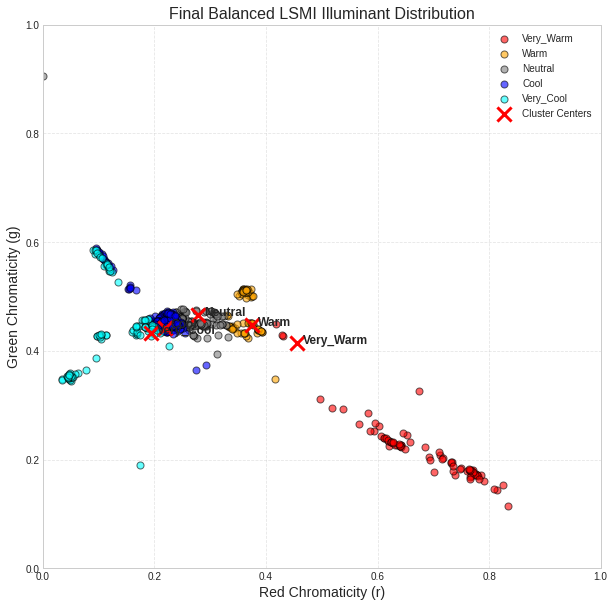

In [40]:
# Plotting
plt.figure(figsize=(10, 10))

# Plot the illuminants
# We can color them by their cluster for clarity
colors = {'Cool': 'blue', 'Very_Cool': 'cyan', 'Neutral': 'gray', 'Warm': 'orange', 'Very_Warm': 'red'}

for label in labels:
    subset = df_balanced[df_balanced['cluster_name'] == label]
    plt.scatter(subset['r'], subset['g'], label=label, alpha=0.6, edgecolors='k', s=50, c=colors.get(label, 'black'))

# Plot the cluster centers
plt.scatter(center_points[:, 0], center_points[:, 1], c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')

# Add labels to centers
for i, txt in enumerate(labels):
    plt.annotate(txt, (center_points[i, 0]+0.01, center_points[i, 1]), fontsize=12, weight='bold')

plt.xlabel('Red Chromaticity (r)', fontsize=14)
plt.ylabel('Green Chromaticity (g)', fontsize=14)
plt.title('Final Balanced LSMI Illuminant Distribution', fontsize=16)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()